In [1]:
#! Simulator
from casadi import *
from numpy import *
import matplotlib.pyplot as plt

In [3]:
N = 50 # number of control intervals
L = 2.7

opti = Opti() # Optimization problem

# ---- decision variables ---------
X = opti.variable(5,N+1) # state trajectory x, y, theta, v, phi
x = X[0,:]
y = X[1,:]
theta = X[2,:]
v = X[3,:]
phi = X[4,:]

U = opti.variable(2,N)   # control trajectory (accleration, phi_dot)
a = U[0,:]
phi_dot = U[1,:]

T = opti.variable()      # Total time

# ---- dynamic constraints --------

def f(x, u):
    # This function return the change in state wrt time
    # X = [x, y, theta, v, phi]
    # dx/dt = f(x,u) = [dx, dy, d_theta, v, phi]
    return vertcat(x[3]*np.cos(x[2]), x[3]*np.sin(x[2]), x[3]*np.tan(x[4])/L, u[0], u[1])

dt = T/N # length of a control interval
for k in range(N): # loop over control intervals
    # Runge-Kutta 4 integration
    k1 = f(X[:,k],         U[:,k])
    k2 = f(X[:,k]+dt/2*k1, U[:,k])
    k3 = f(X[:,k]+dt/2*k2, U[:,k])
    k4 = f(X[:,k]+dt*k3,   U[:,k])
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
    opti.subject_to(X[:,k+1]==x_next) # close the gaps

# ---- constraints -----------
# State limits
opti.subject_to(opti.bounded(-7.75, v, 77.75))   # track speed limit
opti.subject_to(opti.bounded(-0.58206731, phi, 0.58206731))   # steering angle limit
# Control limits
opti.subject_to(opti.bounded(-12.0, a, 4.0))   # steering angle limit
opti.subject_to(opti.bounded(-0.28206731, phi_dot, 0.28206731))   # steering angle limit

# ---- Initial conditions --------
opti.subject_to(x[0]==0)   # start at position 0 ...
opti.subject_to(y[0]==0)   # start at position 0 ...
opti.subject_to(theta[0]==0)   # start at position 0 ...
opti.subject_to(v[0]==0) # ... from stand-still 
opti.subject_to(phi[0]==0)

# Final Conditions
opti.subject_to(x[-1]**2 <= 0.001)
opti.subject_to((y[-1] - 4*L)**2 <= 0.001)
opti.subject_to(theta[-1]==0)
opti.subject_to(phi[-1]==0)
opti.subject_to(v[-1]==0) # ... to stand-still 

# ---- misc. constraints  ----------
opti.subject_to(T>=0) # Time must be positive

# ---- initial values for solver ---
# opti.set_initial(v, 0.0)
# opti.set_initial(phi, 0.0)
opti.set_initial(T, 1)

# ---- objective          ---------
R = 0.01 * np.eye(N)
opti.minimize(T + a@R@a.T + phi_dot@R@phi_dot.T) # race in minimal time

# ---- solve NLP              ------
opti.solver("ipopt") # set numerical backend
sol = opti.solve()   # actual solve


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1558
Number of nonzeros in inequality constraint Jacobian.:      205
Number of nonzeros in Lagrangian Hessian.............:     3453

Total number of variables............................:      356
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

  84r6.1717687e-001 2.99e-001 2.90e-002  -6.5 7.14e-002  -2.5 1.00e+000 1.00e+000h  1
  85r6.3206602e-001 2.99e-001 6.89e+000  -6.5 1.01e-001  -2.1 1.00e+000 1.48e-001h  1
  86r6.2842334e-001 3.00e-001 3.45e-001  -6.5 2.87e-001    -  1.00e+000 8.27e-001f  1
  87r6.2972438e-001 3.00e-001 1.03e-001  -6.5 1.03e-001    -  1.00e+000 5.62e-001h  1
  88r6.3059663e-001 3.00e-001 2.09e-005  -6.5 2.98e-002    -  1.00e+000 1.00e+000h  1
  89r6.3076095e-001 3.00e-001 9.33e-008  -6.5 1.72e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r6.3194541e-001 3.00e-001 7.96e-004  -9.0 1.18e-002    -  9.81e-001 9.69e-001h  1
  91r6.3237042e-001 3.00e-001 1.17e-001  -9.0 2.75e-002  -2.6 1.00e+000 2.05e-001h  1
  92r6.3280689e-001 3.00e-001 2.02e-001  -9.0 7.75e-002  -3.1 1.00e+000 1.80e-001h  1
  93r6.3296359e-001 3.00e-001 5.08e-001  -9.0 2.12e-001  -3.5 1.00e+000 8.66e-002h  1
  94r6.3227981e-001 3.00e-001 1.53e+000  -9.0 7.03e-001  -4

 175r1.1332836e+001 4.63e-001 2.00e+002  -9.0 9.12e-001   2.5 1.45e-001 4.91e-003f  1
In iteration 175, 1 Slack too small, adjusting variable bound
 176r1.1332891e+001 4.63e-001 2.00e+002  -9.0 3.92e+001   2.0 3.29e-004 1.40e-006f  1
In iteration 176, 1 Slack too small, adjusting variable bound
 177r1.1339952e+001 4.64e-001 2.01e+002  -9.0 1.06e+000   2.4 1.04e-001 6.58e-003f  1
In iteration 177, 1 Slack too small, adjusting variable bound
 178r1.1359724e+001 4.66e-001 2.02e+002  -9.0 2.94e-001   2.9 1.30e-001 6.62e-002f  1
In iteration 178, 1 Slack too small, adjusting variable bound
 179r1.1359724e+001 4.66e-001 2.02e+002  -9.0 1.25e+000   2.4 3.70e-002 3.94e-007f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r1.1414004e+001 4.71e-001 2.05e+002  -9.0 3.32e-001   2.8 9.80e-002 1.61e-001f  1
 181r1.1414004e+001 4.71e-001 2.05e+002  -9.0 1.48e+000   2.3 4.95e-002 3.91e-009f  1
 182r1.1427546e+001 4.73e-001 2.05e+002  -9.0 3.81e-001   2.8 8.34e-0

In iteration 250, 1 Slack too small, adjusting variable bound
 251r1.2827283e+001 4.24e-001 3.53e+002  -9.0 5.14e-001   2.4 1.00e+000 9.07e-005f  1
In iteration 251, 1 Slack too small, adjusting variable bound
 252r1.2828986e+001 4.25e-001 3.53e+002  -9.0 1.69e+000   1.9 4.21e-005 1.21e-003f  1
In iteration 252, 1 Slack too small, adjusting variable bound
 253r1.2828986e+001 4.25e-001 3.54e+002  -9.0 5.81e-001   2.3 3.28e-001 2.15e-007f  1
In iteration 253, 1 Slack too small, adjusting variable bound
 254r1.2869602e+001 4.38e-001 3.44e+002  -9.0 1.94e+000   1.8 8.50e-003 2.49e-002f  1
In iteration 254, 1 Slack too small, adjusting variable bound
 255r1.2869602e+001 4.38e-001 3.70e+002  -9.0 6.08e-001   2.3 1.00e+000 1.25e-007f  1
In iteration 255, 1 Slack too small, adjusting variable bound
 256r1.2999331e+001 4.84e-001 3.42e+002  -9.0 2.06e+000   1.8 6.94e-002 7.33e-002f  1
In iteration 256, 1 Slack too small, adjusting variable bound
 257r1.2999331e+001 4.84e-001 3.42e+002  -9.0 6.92

 338r1.6809160e+001 3.89e-001 3.37e+002  -9.0 1.80e+000   1.5 7.04e-008 3.70e-002f  1
In iteration 338, 1 Slack too small, adjusting variable bound
 339r1.6810797e+001 3.89e-001 2.61e+002  -9.0 6.23e-001   1.9 1.00e+000 2.57e-003f  1
In iteration 339, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340r1.7201454e+001 3.30e-001 1.52e+002  -9.0 2.08e+000   1.4 1.22e-006 1.85e-001f  1
In iteration 340, 1 Slack too small, adjusting variable bound
 341r1.7201454e+001 3.30e-001 1.94e+002  -9.0 6.67e-001   1.9 5.08e-001 5.42e-010h  1
In iteration 341, 1 Slack too small, adjusting variable bound
 342r1.7319105e+001 2.92e-001 1.46e+002  -9.0 1.18e+000   1.4 1.79e-005 9.67e-002f  1
In iteration 342, 1 Slack too small, adjusting variable bound
 343r1.7377918e+001 2.73e-001 4.17e+002  -9.0 4.17e-001   1.8 5.91e-001 1.37e-001f  1
In iteration 343, 1 Slack too small, adjusting variable bound
 344r1.7616957e+001 1.84e-001 2

<IPython.core.display.Javascript object>


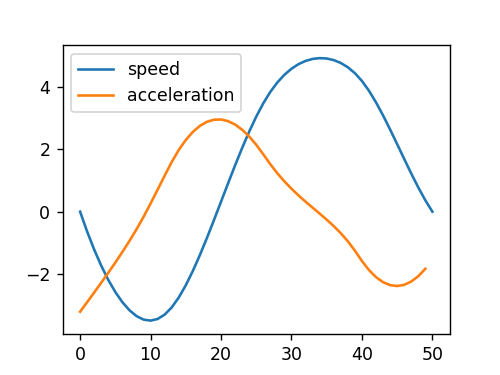

<IPython.core.display.Javascript object>


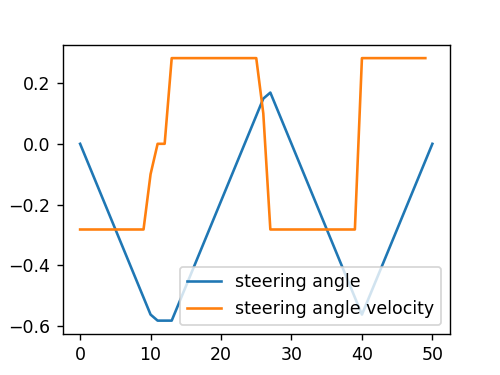

<IPython.core.display.Javascript object>


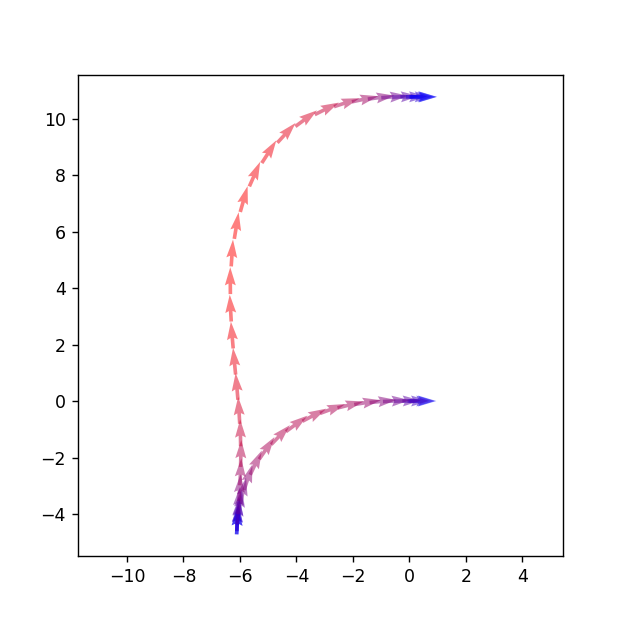

<ipython-input-4-a2f222223653>:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cols = np.interp(cols, (cols.min(), cols.max()), (0, 1)).astype(np.float)


In [4]:
%matplotlib notebook

# Plotting
plt.figure(figsize=(4,3))
plt.plot(sol.value(v),label="speed")
plt.plot(sol.value(a),label="acceleration")
plt.legend(loc="best")
plt.figure(figsize=(4,3))
plt.plot(sol.value(phi),label="steering angle")
plt.plot(sol.value(phi_dot),label="steering angle velocity")
plt.legend(loc="best")

plt.figure(figsize=(5,5))
plt.axis("equal")
xs = sol.value(x)
ys = sol.value(y)
vs = sol.value(v)
thetas = sol.value(theta)

# Creating colors array based on velocity
cols = np.abs(vs)
cols = np.interp(cols, (cols.min(), cols.max()), (0, 1)).astype(np.float)

for i in range(N+1):
    plt.quiver(xs[i], ys[i], np.cos(thetas[i]), np.sin(thetas[i]), color=(cols[i],0,1-cols[i]), alpha=0.5)

plt.show()